In [1]:
# !pip install datasets --upgrade
# !pip install transformers
# !pip install torchvision torch

In [1]:
import os
import json
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
os.chdir("../")
# os.getcwd()

In [4]:
# import requests

# with open("./data/Furniture.json", 'r', encoding='utf-8-sig') as f:
#     furniture = json.load(f)

# for idx, item in enumerate(furniture):
#     url = item["pictureUrl"]
#     response = requests.get(url, timeout=10)
#     with open(f"./data/images/{idx}.jpg", 'wb') as f:
#         f.write(response.content)

In [3]:
with open("./data/Furniture.json", 'r', encoding='utf-8-sig') as f:
    furniture = json.load(f)

with open("./data/colors.json", 'r', encoding='utf-8-sig') as f:
    colors = json.load(f)

print(furniture[0])
print(colors[0])

{'id': 'c3201f1c-ce1c-4f08-a815-9e0f2ff7bb77', 'name': 'HEMNES', 'description': 'Glass door cabinet with 3 drawers black brown', 'pictureUrl': 'https://www.ikea.com/us/en/images/products/hemnes-dressing-table-with-mirror-white__0627085_pe693165_s5.jpg?f=xl', 'furnitureModel': 'https://web-api.ikea.com/dimma/assets/1.2/70371771/PS01_S01_NV01/isp3/glb_draco/70371771_PS01_S01_NV01_ISP3_2.0_226e13b184394ac5ad5be173d5504e10.glb', 'price': 379, 'hasOffer': True, 'offerStartDate': '2023-11-25T00:00:00Z', 'offerEndDate': '2025-11-25T23:59:59Z', 'discountPercentage': 20, 'discountedPrice': 303.2, 'brandId': '7e94f147-004e-4886-8a60-a9f3c98ad1d5', 'categoryId': '1e93f147-004e-4886-8a60-a9f3c98ad1d1', 'styleTypeId': '8e94f147-004e-4886-8a60-a9f3c98ad1d3', 'colorId': '9e94f147-004e-4886-8a60-a9f3c98ad1d2'}
{'color': 'white'}


In [4]:
import torch
from PIL import Image
import torch.nn.functional as F
from transformers import CLIPProcessor, CLIPModel

# load the feature extraction models
MODEL_PATH = "./models/clip_model/"
model = CLIPModel.from_pretrained(MODEL_PATH)
processor = CLIPProcessor.from_pretrained(MODEL_PATH)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


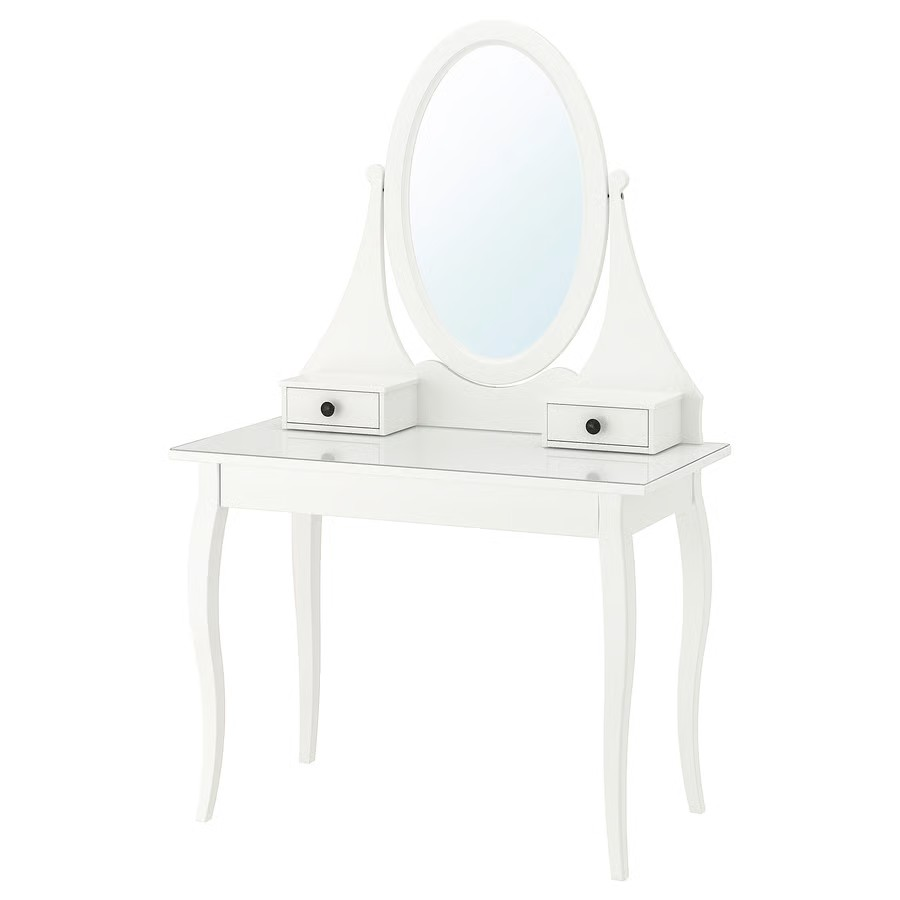

In [5]:
from PIL import Image

img = Image.open("./data/images/0.jpg")
img

In [6]:
len(os.listdir("./data/images/"))

211

In [7]:
# embedding for all images
DATA_ROOT_DIR = "./data/images/"

embedding_vector = []

for idx, elm in enumerate(furniture):
    URL = elm['pictureUrl']
    img = Image.open(f"{DATA_ROOT_DIR}{idx}.jpg")
    # Preprocess image for CLIP
    input = processor(images=img, return_tensors="pt")["pixel_values"]

    with torch.no_grad():
        image_features = model.get_image_features(input)

    # convert the features to unit vector
    # cosine similarity only care about the angle between the feature vectors
    image_features = F.normalize(image_features, dim=-1)
    embedding_vector.append(image_features.cpu().numpy())

embedding_vector[0]

array([[-5.63542657e-02,  3.23445983e-02,  3.42465416e-02,
         1.16431694e-02,  5.92331216e-03,  2.57544480e-02,
         2.13783095e-03,  8.70997086e-03, -2.72879247e-02,
        -9.81260650e-03, -2.93019582e-02, -1.28407637e-02,
        -1.18778162e-02, -1.68595314e-02, -7.08753848e-03,
        -2.47991886e-02, -3.03814262e-02,  2.21914873e-02,
        -8.48719850e-04, -2.45347340e-02,  1.26700196e-02,
         1.84567866e-03,  2.97438968e-02, -4.78688721e-03,
        -1.59953814e-02,  2.50083916e-02, -2.44551748e-02,
        -2.48344447e-02, -1.08600166e-02, -3.90287340e-02,
         4.11991775e-03,  4.14931662e-02,  1.29552530e-02,
        -4.13270947e-03, -3.53651606e-02, -2.77930815e-02,
        -1.92883387e-02,  5.08714281e-03,  2.05202699e-02,
         1.51164830e-01,  3.05025596e-02, -2.34514084e-02,
         3.13994549e-02, -3.77469766e-03,  2.76244488e-02,
        -1.71113670e-01, -3.36602665e-02,  2.72660218e-02,
        -1.01798745e-02,  1.36334244e-02,  2.00423431e-0

In [8]:
embedding_vector = np.asarray(embedding_vector).astype(np.float32)
embedding_vector.shape

(211, 1, 512)

In [9]:
embedding_vector = embedding_vector.squeeze()
embedding_vector.shape

(211, 512)

In [10]:
from qdrant_client import models, QdrantClient
from dotenv import load_dotenv
load_dotenv()

QDRANT_HOST = os.environ["QDRANT_HOST"]
QDRANT_API_KEY = os.environ["QDRANT_API_KEY"]

client = QdrantClient(
    url=QDRANT_HOST,
    api_key=QDRANT_API_KEY,
    timeout=60.0
)

In [11]:
from qdrant_client.http.models import Distance, VectorParams

client.recreate_collection(
    collection_name="image_features",
    vectors_config=VectorParams(size=512, distance=Distance.COSINE),
)

/tmp/ipykernel_11999/1132730971.py:3: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  client.recreate_collection(


True

In [37]:
image_urls = {raw['id']:raw['pictureUrl'] for raw in furniture}
image_urls

{'c3201f1c-ce1c-4f08-a815-9e0f2ff7bb77': 'https://www.ikea.com/us/en/images/products/hemnes-dressing-table-with-mirror-white__0627085_pe693165_s5.jpg?f=xl',
 '898a6dee-66c9-4a71-a2b3-e9a9c010fcc3': 'https://www.ikea.com/us/en/images/products/alex-desk-black-brown__0977660_pe813727_s5.jpg?f=xl',
 '94a205de-6403-483a-8554-2ab1c810584a': 'https://www.ikea.com/eg/en/images/products/hemnes-dressing-table-with-mirror-white__0627085_pe693165_s5.jpg?f=xl',
 '441b47aa-386d-45ce-9ae5-ae7c91000d9a': 'https://www.ikea.com/us/en/images/products/trofast-storage-combination-white-turquoise__0807590_pe770449_s5.jpg?f=xl',
 '4d8da5be-0950-461c-97e2-d1ec6e1ebd00': 'https://www.ikea.com/us/en/images/products/vessla-storage-crate-with-casters-white__0711041_pe727917_s5.jpg?f=xl',
 '40490a41-4208-49a3-90fd-0a6758554db5': 'https://www.ikea.com/us/en/images/products/smagoera-shelf-unit-white__0772937_pe756154_s5.jpg?f=xl',
 'd5bd5cc9-0972-4510-a99c-713185037965': 'https://www.ikea.com/us/en/images/products/f

In [12]:
from qdrant_client.models import PointStruct

points = []

for idx, vector_embed in enumerate(embedding_vector):
    COLOR = colors[idx]['color']

    point = PointStruct(
        id=idx,
        vector=vector_embed.tolist(),
        payload={
            "color":COLOR
        }
    )

    points.append(point)

client.upsert(
    collection_name="image_features",
    points=points,
)

UpdateResult(operation_id=0, status=<UpdateStatus.COMPLETED: 'completed'>)

In [13]:
img = Image.open("./data/images/27.jpg")

input = processor(images=img, return_tensors="pt")["pixel_values"]

with torch.no_grad():
  query_image = model.get_image_features(input)

query_image = F.normalize(query_image, dim=-1)
query_image = query_image.cpu().numpy()[0]
query_image

array([-4.05646972e-02,  3.49123031e-02,  2.55536828e-02, -1.05749639e-02,
        6.76563103e-03,  3.91330048e-02, -8.99889413e-03,  1.67552456e-02,
        2.66954396e-02,  7.43771391e-03,  1.33907245e-02,  3.02516706e-02,
        1.54539933e-02, -3.08122020e-02, -1.67790148e-02, -1.20072474e-03,
        8.86726603e-02,  4.95856963e-02,  3.90015612e-03, -7.54846539e-03,
        2.73414003e-03, -4.99378657e-03,  2.90758573e-02, -1.55201722e-02,
       -2.44131424e-02,  4.91616689e-02,  5.12031280e-02, -3.71858701e-02,
       -2.16361843e-02,  1.36061385e-02,  3.67057249e-02,  1.38923042e-02,
        1.53381573e-02,  8.20191111e-03,  2.82015256e-03, -5.36129735e-02,
       -3.70596386e-02, -3.77446227e-02,  8.27481411e-03,  6.45514876e-02,
       -2.46520005e-02, -2.50376593e-02,  1.32614430e-02,  2.39811372e-02,
       -4.64955997e-03, -1.70290887e-01, -6.34093061e-02, -2.07368713e-02,
        3.28527540e-02,  3.98283601e-02,  1.31359650e-02, -1.47081679e-03,
        5.65845594e-02,  

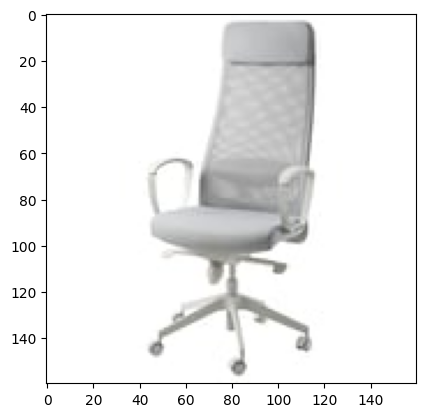

In [14]:
plt.imshow(img)
plt.show()

# Search

In [15]:
search_result = client.search(
    collection_name="image_features",
    query_vector=query_image,
    limit=10
)

/tmp/ipykernel_11999/3866598894.py:1: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_result = client.search(


In [17]:
for hit in search_result:
  print("Score:", hit.score)
  print("Color:", hit.payload["color"])
  idx = hit.id
  print("link:", furniture[idx]['pictureUrl'])
  print("-"*20)

Score: 1.0
Color: grey
link: https://www.ikea.com/in/en/images/products/markus-office-chair-vissle-light-grey__1101440_pe866425_s5.jpg?f=u
--------------------
Score: 0.96172154
Color: black
link: https://www.ikea.com/in/en/images/products/markus-office-chair-vissle-dark-grey__0724714_pe734597_s5.jpg?f=u
--------------------
Score: 0.9558483
Color: beige
link: https://www.ikea.com/in/en/images/products/flintan-office-chair-with-armrests-beige__1007238_pe825958_s5.jpg?f=u
--------------------
Score: 0.95072246
Color: black
link: https://www.ikea.com/in/en/images/products/flintan-office-chair-with-armrests-black__1007241_pe825960_s5.jpg?f=u
--------------------
Score: 0.9490824
Color: white
link: https://www.ikea.com/in/en/images/products/hattefjaell-office-chair-with-armrests-gunnared-light-green-white__1179624_pe896024_s5.jpg?f=u
--------------------
Score: 0.94821227
Color: white
link: https://www.ikea.com/in/en/images/products/skruvsta-swivel-chair-ysane-white__0724712_pe734595_s5.jp

# Color filter Search

In [18]:
from qdrant_client.http import models

client.create_payload_index(
    collection_name="image_features",
    field_name="color",
    field_schema=models.PayloadSchemaType.KEYWORD  # exact match indexing
)

UpdateResult(operation_id=2, status=<UpdateStatus.COMPLETED: 'completed'>)

In [19]:
from qdrant_client.http import models

search_result = client.search(
    collection_name="image_features",
    query_vector=query_image,
    limit=10,
    query_filter=models.Filter(
        must=[
            models.FieldCondition(
                key="color",
                match=models.MatchValue(value="black")
            )
        ]
    )
)

/tmp/ipykernel_11999/1181123447.py:3: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_result = client.search(


In [20]:
for hit in search_result:
  print("Score:", hit.score)
  print("Color:", hit.payload["color"])
  idx = hit.id
  print("link:", furniture[idx]['pictureUrl'])
  print("-"*20)

Score: 0.96172154
Color: black
link: https://www.ikea.com/in/en/images/products/markus-office-chair-vissle-dark-grey__0724714_pe734597_s5.jpg?f=u
--------------------
Score: 0.95072246
Color: black
link: https://www.ikea.com/in/en/images/products/flintan-office-chair-with-armrests-black__1007241_pe825960_s5.jpg?f=u
--------------------
Score: 0.9362669
Color: black
link: https://www.ikea.com/in/en/images/products/groenfjaell-office-chair-with-armrests-letafors-grey-black__1273321_pe930000_s5.jpg?f=u
--------------------
Score: 0.88356596
Color: black
link: https://www.ikea.com/in/en/images/products/lidas-chair-black-sefast-white__1167052_pe891354_s5.jpg?f=u
--------------------
Score: 0.87749714
Color: black
link: https://www.ikea.com/in/en/images/products/lidas-chair-black-sefast-chrome-plated__1167047_pe891349_s5.jpg?f=u
--------------------
Score: 0.8774915
Color: black
link: https://www.ikea.com/in/en/images/products/poaeng-armchair-brown-knisa-black__0571538_pe666953_s5.jpg?f=u
--